# Neural Collaborative Filtering

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, he_normal, he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt

In [14]:
tf.config.list_physical_devices('GPU')

[]

In [15]:
train = pd.read_csv("data\\train-plays.csv").drop(columns=["norm_amount", "amount"])
test = pd.read_csv("data\\test-plays.csv").drop(columns=["norm_amount", "amount"])
game_coding = pd.read_csv("data\\game-coding.csv")

## Format training data

In [16]:
train['played'] = 1

In [17]:
rand_users = np.random.randint(0, train.user_id.unique().size, train.shape[0] * 50)
rand_games = np.random.randint(0, train.game_id.unique().size, train.shape[0] * 50)
neg_train = pd.DataFrame({"user_id":rand_users, "game_id":rand_games})
neg_train

,user_id,game_id
0,888,634
1,264,793
2,784,21
3,3113,100
4,2822,363
...,...,...
1994645,763,662
1994646,1292,724
1994647,3087,643
1994648,1617,951


In [18]:
train = train.append(neg_train).drop_duplicates(subset=['game_id', 'user_id'])
train.played = np.where(train.played != 1, 0, 1)
train = train.sample(frac=1.0)
train

,game_id,user_id,played
536487,920,1332,0
1019989,97,148,0
1769158,857,1962,0
17530,49,467,1
100525,823,323,0
...,...,...,...
232994,124,2736,0
1769083,771,2588,0
1022935,307,2697,0
766109,718,3206,0


In [19]:
print(train[train.played == 0].shape[0]/train.shape[0])
print(train[train.played == 1].shape[0]/train.shape[0])

0.974175878238939
0.025824121761061008


In [20]:
# check to make sure didn't introduce conflicting neg training instances
train.groupby(by=['user_id']).agg({'game_id':lambda x: x.unique().size == x.size})['game_id'].all()

True

## Neural Network Construction

In [21]:
n_epochs = 50

### Multi-Layer Perceptron part of model

In [22]:
mlp_latent_factors = 16

# game inputs and embeddings
game_input = keras.layers.Input(shape=[1], name='MLP-Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, mlp_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='MLP-Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='MLP-Flatten-Games')(game_embedding)

# user inputs and embeddings
user_input = keras.layers.Input(shape=[1], name='MLP-User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, mlp_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='MLP-User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='MLP-Flatten-Users')(user_embedding)

mlp_layer = keras.layers.concatenate([game_vec, user_vec], name="MLP-User-Games")

for i in [4, 2, 1, 0.5, 0.25, 0]:
  mlp_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform', 
              activity_regularizer=l2(0.01))(mlp_layer)
  mlp_layer = Dense(math.floor(mlp_latent_factors * i), activation='relu', 
              kernel_initializer='he_uniform', 
              activity_regularizer=l2(0.01))(mlp_layer)
  if i == 4:
    mlp_layer = BatchNormalization()(mlp_layer)
  mlp_layer = Dropout(0.2)(mlp_layer)

mlp = Model(inputs=[user_input, game_input], outputs=mlp_output)
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [23]:
# train mlp weights
early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
mlp_history = mlp.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs, callbacks=[early_stop])

Train on 1544796 samples
Epoch 1/50
1544796/1544796 [==============================] - 43s 28us/sample - loss: 0.1641 - binary_accuracy: 0.9705
Epoch 2/50
1544796/1544796 [==============================] - 39s 25us/sample - loss: 0.1212 - binary_accuracy: 0.9742
Epoch 3/50
1544796/1544796 [==============================] - 39s 25us/sample - loss: 0.1200 - binary_accuracy: 0.9742
Epoch 4/50
1544796/1544796 [==============================] - 39s 25us/sample - loss: 0.1199 - binary_accuracy: 0.9742
Epoch 5/50
1544796/1544796 [==============================] - 39s 25us/sample - loss: 0.1199 - binary_accuracy: 0.9742
Epoch 6/50
1544796/1544796 [==============================] - 39s 25us/sample - loss: 0.1199 - binary_accuracy: 0.9742
Epoch 7/50
1544796/1544796 [==============================] - 40s 26us/sample - loss: 0.1199 - binary_accuracy: 0.9742
Epoch 8/50
1544796/1544796 [==============================] - 40s 26us/sample - loss: 0.1199 - binary_accuracy: 0.9742
Epoch 9/50
1544796/1544

Text(0, 0.5, 'Training Error')

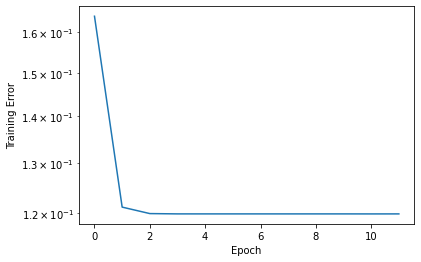

In [24]:
pd.Series(mlp_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [25]:
# lock mlp weights
mlp.trainable = False
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

### Generalized Matrix Factorization part of model

In [42]:
gmf_latent_factors = 32

# game inputs and embeddings
game_input = keras.layers.Input(shape=[1], name='GMF-Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, gmf_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='GMF-Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='GMF-Flatten-Games')(game_embedding)

# user inputs and embeddings
user_input = keras.layers.Input(shape=[1], name='GMF-User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, gmf_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='GMF-User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='GMF-Flatten-Users')(user_embedding)

prod = keras.layers.dot([user_vec, game_vec], axes=1, name='Dot-Product')

gmf = Model(inputs=[user_input, game_input], outputs=prod)
gmf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [43]:
# train gmf weights
gmf_history = gmf.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs)

Train on 1544796 samples
Epoch 1/50
1544796/1544796 [==============================] - 27s 18us/sample - loss: 0.0230 - mae: 0.0386 - mse: 0.0228
Epoch 2/50
1544796/1544796 [==============================] - 26s 17us/sample - loss: 0.0221 - mae: 0.0413 - mse: 0.0219
Epoch 3/50
1544796/1544796 [==============================] - 26s 17us/sample - loss: 0.0213 - mae: 0.0420 - mse: 0.0210
Epoch 4/50
1544796/1544796 [==============================] - 26s 17us/sample - loss: 0.0207 - mae: 0.0421 - mse: 0.0203
Epoch 5/50
1544796/1544796 [==============================] - 26s 17us/sample - loss: 0.0203 - mae: 0.0419 - mse: 0.0198
Epoch 6/50
1544796/1544796 [==============================] - 26s 17us/sample - loss: 0.0200 - mae: 0.0416 - mse: 0.0194
Epoch 7/50
1544796/1544796 [==============================] - 26s 17us/sample - loss: 0.0198 - mae: 0.0413 - mse: 0.0191
Epoch 8/50
1544796/1544796 [==============================] - 26s 17us/sample - loss: 0.0196 - mae: 0.0410 - mse: 0.0188
Epoch 9

Text(0, 0.5, 'Training Error')

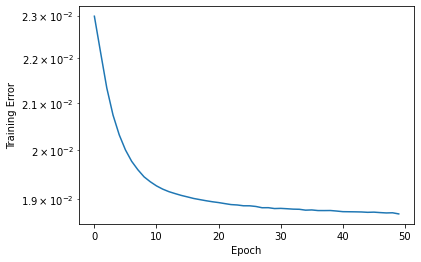

In [44]:
pd.Series(gmf_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [45]:
# lock gmf weights
gmf.trainable = False
gmf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [46]:
# Combining MLP and GMF parts of the model
mlp_gmf = Concatenate()([mlp.output, gmf.output])
ncf_output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform', name='NCF-Output')(mlp_gmf)
ncf = Model([mlp.input, gmf.input], ncf_output)
ncf.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [47]:
ncf.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MLP-Game (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
MLP-User (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
MLP-Game-Embedding (Embedding)  (None, 1, 16)        16528       MLP-Game[0][0]                   
__________________________________________________________________________________________________
MLP-User-Embedding (Embedding)  (None, 1, 16)        54512       MLP-User[0][0]                   
____________________________________________________________________________________________

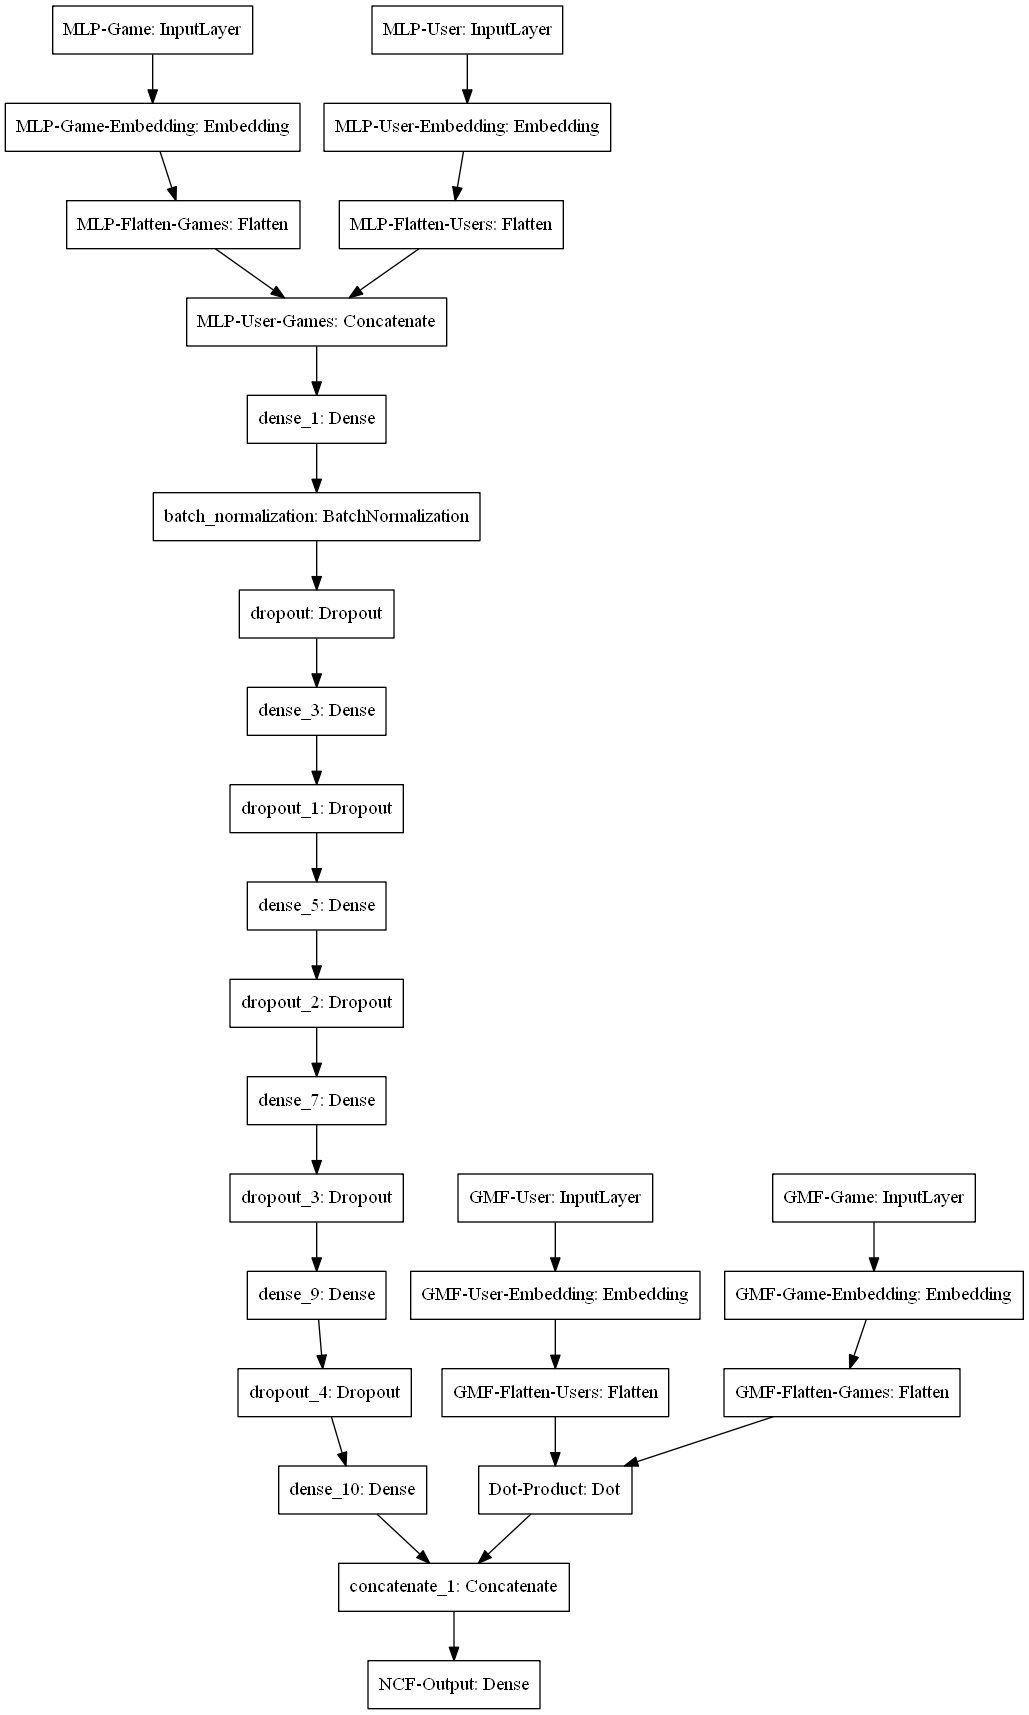

In [48]:
plot_model(ncf)

## Model Training

In [49]:
# train ncf
early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
ncf_history = ncf.fit([train.user_id, train.game_id, train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs, callbacks=[early_stop])

Train on 1544796 samples
Epoch 1/50
1544796/1544796 [==============================] - 23s 15us/sample - loss: 0.1570 - binary_accuracy: 0.9733
Epoch 2/50
1544796/1544796 [==============================] - 22s 14us/sample - loss: 0.1146 - binary_accuracy: 0.9742
Epoch 3/50
1544796/1544796 [==============================] - 22s 14us/sample - loss: 0.1112 - binary_accuracy: 0.9742
Epoch 4/50
1544796/1544796 [==============================] - 22s 14us/sample - loss: 0.1082 - binary_accuracy: 0.9742
Epoch 5/50
1544796/1544796 [==============================] - 22s 15us/sample - loss: 0.1054 - binary_accuracy: 0.9742
Epoch 6/50
1544796/1544796 [==============================] - 22s 14us/sample - loss: 0.1028 - binary_accuracy: 0.9742
Epoch 7/50
1544796/1544796 [==============================] - 22s 14us/sample - loss: 0.1003 - binary_accuracy: 0.9742
Epoch 8/50
1544796/1544796 [==============================] - 22s 14us/sample - loss: 0.0980 - binary_accuracy: 0.9744
Epoch 9/50
1544796/1544

Text(0, 0.5, 'Training Error')

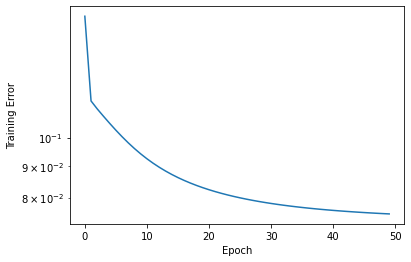

In [50]:
pd.Series(ncf_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

## Model Analysis

In [51]:
def recommend_game(uid, model, n=10):
    uid_array = np.repeat(uid, game_coding.game_id.size)
    recs = np.ndarray.flatten(model.predict([uid_array, game_coding.game_id, uid_array, game_coding.game_id]))
    recs_df =  pd.DataFrame({'game_id':game_coding.game_id, 'rec_confidence':recs})
    return set(recs_df.sort_values(by='rec_confidence', ascending=False).head(10).game_id)

In [52]:
test['recommended'] = np.vectorize(recommend_game)(test.user_id.unique(), ncf)

In [53]:
test['in_recommendations'] = np.vectorize(lambda gid, recs: 1 if gid in recs else 0)(test.game_id, test.recommended)
test.in_recommendations.sum() / test.in_recommendations.size

0.24537716466099208

In [54]:
games_recommended = set()
np.vectorize(lambda curr_games, total: total.update(curr_games))(test.recommended, games_recommended)

array([None, None, None, ..., None, None, None], dtype=object)

In [55]:
len(games_recommended) / train.game_id.unique().size

0.3020329138431752